In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 04/03/2021

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 04/03/2021\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt
from generator import extract_days_timestamps_volumes_labels_days_with_regulations, \
                      extract_features_from_list_days_and_timestamps

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [4]:
# sectorName = 'BOLN'
# sectorName = 'D6WH'
# sectorName = 'B3EH'

# sectorName = 'HRHR'
# sectorName = 'HSOL'
# sectorName = 'B3LL'

sectorName = 'D3WLC'

In [5]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [6]:
num_epochs = 200
batch_size = 32

# Used to extract more samples from a particular sector
if sectorName == 'BOLN':
    num_additional_samples_per_day = 25
else:
    num_additional_samples_per_day = 75

In [7]:
# num_weather_features = 7
num_weather_features = 16
num_metric_per_weather_feature = 3

# Prepare / Extreact data

###  Extract the available regulations

In [8]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == ' MAS'+sectorName+' ') &
                                                (REGULATIONS["regulation_reason"].isin([' W-Weather '])) & 
                                                (REGULATIONS["location_type"] == ' En route ') &
                                                (REGULATIONS["cancel_time"] == '  ')
                                               ]



In [9]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS_from_given_sector.loc[:, 'date_DDMMYYYY'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS_from_given_sector.loc[:, 'start_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS_from_given_sector.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS_from_given_sector = REGULATIONS_from_given_sector.drop(index=index)

In [11]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS_from_given_sector.values)))

Number regulations AFTER pre-processing:  9


### Extract the different list of days and timestamps

##### Samples without regulations from days without regulations

In [12]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [13]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [14]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,50)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Append the day of the timestamp
        list_days_without_regulations_extended.append(day)
        
        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

In [15]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), \
len(end_time_samples_no_regulations)

(91, 91, 91)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible to have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [16]:
REGULATIONS_from_given_sector.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [17]:
list_dates_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

start_regulations = REGULATIONS_from_given_sector["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS_from_given_sector["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS_from_given_sector["traffic_volume"].values

In [18]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(
                                          list_dates_with_regulations, 
                                          start_regulations,
                                          end_regulations,
                                          list_volumes_regulations, 
                                          gap_before_start_time, 
                                          gap_after_start_time, 
                                          num_additional_samples_per_day=num_additional_samples_per_day,
                                          min_timestamps_with_regulations=10)

In [19]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(198, 198, 198, 198)

# Extract all the features for the given dates and timestamps

In [20]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)

In [21]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(91, 30, 11)

In [22]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(list_days_without_regulations_extended, 
                                                                           start_time_samples_no_regulations, 
                                                                           end_time_samples_no_regulations,
                                                                           sectorName,
                                                                           gap_before_start_time, gap_after_start_time,
                                                                           X_days_without_regulations)

D3WLC | counter: 1
D3WLC | counter: 2
D3WLC | counter: 3
D3WLC | counter: 4
D3WLC | counter: 5
D3WLC | counter: 6
D3WLC | counter: 7
D3WLC | counter: 8
D3WLC | counter: 9
D3WLC | counter: 10
D3WLC | counter: 11
D3WLC | counter: 12
D3WLC | counter: 13
D3WLC | counter: 14
D3WLC | counter: 15
D3WLC | counter: 16
D3WLC | counter: 17
D3WLC | counter: 18
D3WLC | counter: 19
D3WLC | counter: 20
D3WLC | counter: 21
D3WLC | counter: 22
D3WLC | counter: 23
D3WLC | counter: 24
D3WLC | counter: 25
D3WLC | counter: 26
D3WLC | counter: 27
D3WLC | counter: 28
D3WLC | counter: 29
D3WLC | counter: 30
D3WLC | counter: 31
D3WLC | counter: 32
D3WLC | counter: 33
D3WLC | counter: 34
D3WLC | counter: 35
D3WLC | counter: 36
D3WLC | counter: 37
D3WLC | counter: 38
D3WLC | counter: 39
D3WLC | counter: 40
D3WLC | counter: 41
D3WLC | counter: 42
D3WLC | counter: 43
D3WLC | counter: 44
D3WLC | counter: 45
D3WLC | counter: 46
D3WLC | counter: 47
D3WLC | counter: 48
D3WLC | counter: 49
D3WLC | counter: 50
D3WLC | c

In [23]:
np.save('./Counting_variables/Weather/X_days_without_regulations', X_days_without_regulations)

In [24]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)

In [25]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), 
                                    int(gap_before_start_time+gap_after_start_time), 
                                    11))
X_days_from_regulations.shape

(198, 30, 11)

In [26]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       sectorName,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

D3WLC | counter: 1
D3WLC | counter: 2
D3WLC | counter: 3
D3WLC | counter: 4
D3WLC | counter: 5
D3WLC | counter: 6
D3WLC | counter: 7
D3WLC | counter: 8
D3WLC | counter: 9
D3WLC | counter: 10
D3WLC | counter: 11
D3WLC | counter: 12
D3WLC | counter: 13
D3WLC | counter: 14
D3WLC | counter: 15
D3WLC | counter: 16
D3WLC | counter: 17
D3WLC | counter: 18
D3WLC | counter: 19
D3WLC | counter: 20
D3WLC | counter: 21
D3WLC | counter: 22
D3WLC | counter: 23
D3WLC | counter: 24
D3WLC | counter: 25
D3WLC | counter: 26
D3WLC | counter: 27
D3WLC | counter: 28
D3WLC | counter: 29
D3WLC | counter: 30
D3WLC | counter: 31
D3WLC | counter: 32
D3WLC | counter: 33
D3WLC | counter: 34
D3WLC | counter: 35
D3WLC | counter: 36
D3WLC | counter: 37
D3WLC | counter: 38
D3WLC | counter: 39
D3WLC | counter: 40
D3WLC | counter: 41
D3WLC | counter: 42
D3WLC | counter: 43
D3WLC | counter: 44
D3WLC | counter: 45
D3WLC | counter: 46
D3WLC | counter: 47
D3WLC | counter: 48
D3WLC | counter: 49
D3WLC | counter: 50
D3WLC | c

In [27]:
np.save('./Counting_variables/Weather/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/Weather/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [28]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                               int(gap_before_start_time+gap_after_start_time), 
                                               num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(91, 30, 48)

In [29]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 05/06/2019 | start:130900 | TV: D3WLC
day: 06/06/2019 | start:154100 | TV: D3WLC
day: 07/06/2019 | start:040400 | TV: D3WLC
day: 08/06/2019 | start:200600 | TV: D3WLC
day: 09/06/2019 | start:143700 | TV: D3WLC
day: 10/06/2019 | start:043200 | TV: D3WLC
day: 11/06/2019 | start:090200 | TV: D3WLC
day: 13/06/2019 | start:052700 | TV: D3WLC
day: 14/06/2019 | start:160400 | TV: D3WLC
day: 15/06/2019 | start:100500 | TV: D3WLC
day: 16/06/2019 | start:202700 | TV: D3WLC
day: 17/06/2019 | start:043600 | TV: D3WLC
day: 18/06/2019 | start:061400 | TV: D3WLC
day: 20/06/2019 | start:210300 | TV: D3WLC
day: 21/06/2019 | start:213700 | TV: D3WLC
day: 22/06/2019 | start:150300 | TV: D3WLC
day: 23/06/2019 | start:100200 | TV: D3WLC
day: 24/06/2019 | start:200800 | TV: D3WLC
day: 25/06/2019 | start:122600 | TV: D3WLC
day: 26/06/2019 | start:073400 | TV: D3WLC
day: 27/06/2019 | start:063600 | TV: D3WLC
day: 28/06/2019 | start:123500 | TV: D3WLC
day: 29/06/2019 | start:080600 | TV: D3WLC
day: 30/06/

In [30]:
np.save('./Counting_variables/Weather/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [31]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(198, 30, 48)

In [32]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 04/06/2019 | start:151300 | TV: D3WLC
day: 04/06/2019 | start:091400 | TV: D3WLC
day: 04/06/2019 | start:172000 | TV: D3WLC
day: 04/06/2019 | start:201600 | TV: D3WLC
day: 04/06/2019 | start:144900 | TV: D3WLC
day: 04/06/2019 | start:031400 | TV: D3WLC
day: 04/06/2019 | start:151900 | TV: D3WLC
day: 04/06/2019 | start:181700 | TV: D3WLC
day: 04/06/2019 | start:064100 | TV: D3WLC
day: 04/06/2019 | start:174000 | TV: D3WLC
day: 04/06/2019 | start:182900 | TV: D3WLC
day: 04/06/2019 | start:193300 | TV: D3WLC
day: 04/06/2019 | start:074400 | TV: D3WLC
day: 04/06/2019 | start:192900 | TV: D3WLC
day: 04/06/2019 | start:204400 | TV: D3WLC
day: 04/06/2019 | start:193100 | TV: D3WLC
day: 04/06/2019 | start:141100 | TV: D3WLC
day: 04/06/2019 | start:182200 | TV: D3WLC
day: 04/06/2019 | start:034000 | TV: D3WLC
day: 04/06/2019 | start:094000 | TV: D3WLC
day: 04/06/2019 | start:165000 | TV: D3WLC
day: 04/06/2019 | start:153900 | TV: D3WLC
day: 04/06/2019 | start:151500 | TV: D3WLC
day: 04/06/

day: 31/08/2019 | start:092600 | TV: D3WLC
day: 31/08/2019 | start:174700 | TV: D3WLC
day: 31/08/2019 | start:132200 | TV: D3WLC
day: 31/08/2019 | start:174100 | TV: D3WLC
day: 31/08/2019 | start:193500 | TV: D3WLC
day: 31/08/2019 | start:142500 | TV: D3WLC
day: 31/08/2019 | start:201100 | TV: D3WLC


In [33]:
np.save('./Counting_variables/Weather/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [306]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/Weather/labels_days_from_regulations.npy')

In [307]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

# X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
#                                                    X_days_without_regulations.shape[1],
#                                                    X_days_without_regulations.shape[2]))

X_days_without_regulations_concatenate.shape

(89, 30, 59)

In [308]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

# X_days_without_regulations_concatenate = X_days_without_regulations

In [309]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

# X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
#                                                 X_days_from_regulations.shape[1],
#                                                 X_days_from_regulations.shape[2]))


X_days_from_regulations_concatenate.shape

(246, 30, 59)

In [310]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

# X_days_from_regulations_concatenate = X_days_from_regulations

# Create the labels

In [311]:
Y_days_without_regulations = np.zeros((X_days_without_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [312]:
Y_days_without_regulations.shape

(89, 30, 1)

In [313]:
Y_from_regulations = np.zeros((X_days_from_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [314]:
Y_from_regulations = labels_days_from_regulations

In [315]:
Y_from_regulations.shape

(246, 30, 1)

# Split into training & testing - By day

In [316]:
X_days_without_regulations_concatenate.shape, Y_days_without_regulations.shape

((89, 30, 59), (89, 30, 1))

In [317]:
X_days_from_regulations_concatenate.shape, Y_from_regulations.shape

((246, 30, 59), (246, 30, 1))

In [318]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

62

In [319]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

172

In [320]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [321]:
X_train.shape, y_train.shape

((234, 30, 59), (234, 30, 1))

In [322]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [323]:
X_test.shape, y_test.shape

((101, 30, 59), (101, 30, 1))

# Only using the max values form the weather features

In [324]:
X_train.shape, X_test.shape

((234, 30, 59), (101, 30, 59))

In [325]:
list_weather_features_delete = []
for i in range(num_weather_features):
    list_weather_features_delete.append(0+i*num_metric_per_weather_feature)  # Minimum
    list_weather_features_delete.append(1+i*num_metric_per_weather_feature)  # Average
#     list_weather_features_delete.append(2+i*num_metric_per_weather_feature)  # Maximum
    
# Additional elements added to the delete list
list_weather_features_delete.append(1*3-1)
list_weather_features_delete.append(3*3-1)

# list_weather_features_delete.append(4*3-1)
# list_weather_features_delete.append(5*3-1)
# list_weather_features_delete.append(6*3-1)
# list_weather_features_delete.append(3*3-1)

In [326]:
X_train_del = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2]-len(list_weather_features_delete)))
X_test_del = np.zeros((X_test.shape[0], X_test.shape[1], X_train.shape[2]-len(list_weather_features_delete)))

for j in range(X_train.shape[0]):
    X_train_del[j] = np.delete(X_train[j], list_weather_features_delete, axis=1)
for j in range(X_test.shape[0]):
    X_test_del[j] = np.delete(X_test[j], list_weather_features_delete, axis=1)


In [327]:
X_train_del.shape, X_test_del.shape

((234, 30, 25), (101, 30, 25))

In [328]:
# Used it to avoid having to change the name of the variables in the following lines
X_train = X_train_del
X_test = X_test_del

# Using StandardScaler from sklearn.preprocessing

In [329]:
from sklearn.preprocessing import StandardScaler

In [330]:
X_train.shape

(234, 30, 25)

In [331]:
X_train_flatten = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_test_flatten = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_train.shape[2]))

# X_train_flatten = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 59))
# X_test_flatten = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 59))

In [332]:
X_train_flatten.shape, X_test_flatten.shape

((7020, 25), (3030, 25))

In [333]:
scaler = StandardScaler()
scaler.fit(X_train_flatten)
X_sc_train = scaler.transform(X_train_flatten)
X_sc_test = scaler.transform(X_test_flatten)

In [334]:
X_train_sc = np.reshape(X_train, (X_train.shape))
X_test_sc = np.reshape(X_test, (X_test.shape))

In [335]:
X_train_sc.shape, X_test_sc.shape

((234, 30, 25), (101, 30, 25))

In [336]:
# X_sc_train = np.zeros((X_train.shape))
# X_sc_test = np.zeros((X_test.shape))

In [337]:
# # Fit and store a scaler for each channel

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = StandardScaler()
#     X_sc_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_sc_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

# Train the model

In [338]:
from keras.layers import BatchNormalization, Bidirectional
from keras.models import Sequential

In [339]:
# def Hotspoter_v2(input_shape):

#     daily_traffic = Input(shape=input_shape)
    
#     X = LSTM(X_train.shape[2], return_sequences=True)(daily_traffic)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)

#     X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)
    
# #     X = LSTM(X_train.shape[2]*3, return_sequences = True)(X)
# #     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2], return_sequences = True)(X)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)

# #     X = LSTM(10, return_sequences = True)(X)
# #     X = Dropout(0.5)(X)
    
#     X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
#     model = Model(inputs=daily_traffic, outputs=X)

    
#     return model

In [398]:
def Hotspoter_v2(input_shape):

    daily_traffic = Input(shape=input_shape)
    
    X = Bidirectional(LSTM(X_train.shape[2], return_sequences=True), merge_mode='ave')(daily_traffic)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)
    
    X = Bidirectional(LSTM(X_train.shape[2]*2, return_sequences = True), merge_mode='ave')(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)

    X = Bidirectional(LSTM(X_train.shape[2], return_sequences = True), merge_mode='ave')(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)

#     X = Bidirectional(LSTM(10, return_sequences = True), merge_mode='ave')(X)
#     X = Dropout(0.5)(X)
#     X = BatchNormalization()(X)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=daily_traffic, outputs=X)

    
    return model

In [399]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v2((num_timestamps_per_sample, X_train.shape[2]))
# model = Hotspoter_v2([num_timestamps_per_sample, num_weather_features*num_metric_per_weather_feature+11])

model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 30, 25)            0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 30, 25)            10200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 30, 25)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 25)            100       
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 30, 50)            30400     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 50)            200

In [400]:
# Anopther option: sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [401]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 200, batch_size = batch_size, shuffle=True)

# history = model.fit(X_train_sc, y_train, 
#                     validation_data = (X_test_sc, y_test),
#                     epochs = 300, batch_size = batch_size, shuffle=True)

Train on 234 samples, validate on 101 samples
Epoch 1/200
234/234 [==============================] - 4s 16ms/step - loss: 0.8192 - accuracy: 0.5316 - val_loss: 0.6873 - val_accuracy: 0.6653
Epoch 2/200
234/234 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.6138 - val_loss: 0.6870 - val_accuracy: 0.5752
Epoch 3/200
234/234 [==============================] - 1s 3ms/step - loss: 0.6002 - accuracy: 0.6789 - val_loss: 0.6805 - val_accuracy: 0.6040
Epoch 4/200
234/234 [==============================] - 1s 3ms/step - loss: 0.5503 - accuracy: 0.7212 - val_loss: 0.6700 - val_accuracy: 0.6795
Epoch 5/200
234/234 [==============================] - 1s 3ms/step - loss: 0.5232 - accuracy: 0.7544 - val_loss: 0.6589 - val_accuracy: 0.6792
Epoch 6/200
234/234 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 0.7674 - val_loss: 0.6456 - val_accuracy: 0.7142
Epoch 7/200
234/234 [==============================] - 1s 3ms/step - loss: 0.4725 - accuracy: 0

234/234 [==============================] - 1s 3ms/step - loss: 0.2087 - accuracy: 0.9251 - val_loss: 0.6264 - val_accuracy: 0.8059
Epoch 58/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1952 - accuracy: 0.9321 - val_loss: 0.6354 - val_accuracy: 0.8036
Epoch 59/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1956 - accuracy: 0.9298 - val_loss: 0.6120 - val_accuracy: 0.8294
Epoch 60/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1813 - accuracy: 0.9380 - val_loss: 0.6358 - val_accuracy: 0.8376
Epoch 61/200
234/234 [==============================] - 1s 3ms/step - loss: 0.2464 - accuracy: 0.9142 - val_loss: 0.7003 - val_accuracy: 0.8069
Epoch 62/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1752 - accuracy: 0.9484 - val_loss: 1.2598 - val_accuracy: 0.6578
Epoch 63/200
234/234 [==============================] - 1s 3ms/step - loss: 0.2029 - accuracy: 0.9303 - val_loss: 1.2602 - val_accuracy: 0.6766
Epoch

Epoch 114/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1599 - accuracy: 0.9467 - val_loss: 0.8477 - val_accuracy: 0.7386
Epoch 115/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1333 - accuracy: 0.9561 - val_loss: 0.9912 - val_accuracy: 0.7119
Epoch 116/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1285 - accuracy: 0.9550 - val_loss: 0.8918 - val_accuracy: 0.7218
Epoch 117/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1155 - accuracy: 0.9634 - val_loss: 0.7615 - val_accuracy: 0.7848
Epoch 118/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9550 - val_loss: 0.7783 - val_accuracy: 0.7809
Epoch 119/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1582 - accuracy: 0.9415 - val_loss: 0.8558 - val_accuracy: 0.7422
Epoch 120/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1366 - accuracy: 0.9577 - val_loss: 0.8968 - val_ac

234/234 [==============================] - 1s 3ms/step - loss: 0.1238 - accuracy: 0.9547 - val_loss: 1.0473 - val_accuracy: 0.6901
Epoch 171/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1189 - accuracy: 0.9547 - val_loss: 0.9887 - val_accuracy: 0.7330
Epoch 172/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1328 - accuracy: 0.9553 - val_loss: 0.9702 - val_accuracy: 0.7482
Epoch 173/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.9580 - val_loss: 0.9561 - val_accuracy: 0.7353
Epoch 174/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1149 - accuracy: 0.9561 - val_loss: 1.0215 - val_accuracy: 0.6927
Epoch 175/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.9553 - val_loss: 1.0123 - val_accuracy: 0.7112
Epoch 176/200
234/234 [==============================] - 1s 3ms/step - loss: 0.1263 - accuracy: 0.9541 - val_loss: 0.9867 - val_accuracy: 0.7399

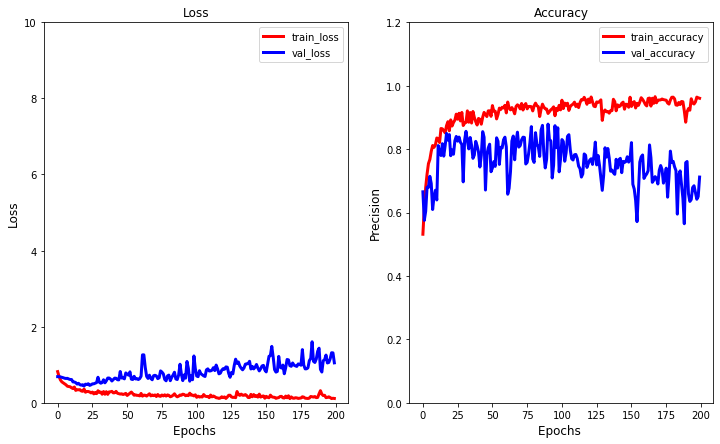

In [402]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [403]:
from metrics import confusion_matrix_sequencialOutput, confusion_matrix_sequencial_output_mean_std

### Training samples

In [404]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_train, y_train, 
                                                                (gap_before_start_time + gap_after_start_time))

In [405]:
conf_matrix

array([[3052.,  323.],
       [ 108., 3537.]])

In [406]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")
print("F1-score training: %.2f" % (2*((TP/(TP+FN))*(TP/(TP+FP)))/((TP/(TP+FN))+(TP/(TP+FP)))))

Accuracy training: 93.86%
Recall training: 96.58%
Precicion training: 90.43%
F1-score training: 0.93


### Testing samples

In [407]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_test, y_test, 
                                                                (gap_before_start_time + gap_after_start_time))

In [408]:
conf_matrix

array([[ 590.,  164.],
       [ 709., 1567.]])

In [409]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100 + 4) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")
print("F1-score testing: %.2f" % (2*((TP/(TP+FN))*(TP/(TP+FP)))/((TP/(TP+FN))+(TP/(TP+FP)))))

Accuracy testing: 71.19%
Recall testing: 49.42%
Precicion testing: 78.25%
F1-score testing: 0.57


# Analysing similaritis

In [410]:
from metrics import similarity_sequential_output_percentage_correct, updated_detect_regulations_binary_mean_std

In [411]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 90)

/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather/metrics.py:248: RuntimeWarning: invalid value encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample
/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather/metrics.py:248: RuntimeWarning: divide by zero encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample


In [412]:
equal, similar, incorrect

(0.5841584158415841, 0.07920792079207921, 0.33663366336633666)

# From many-to-many to many-to-one

In [413]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary

In [414]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [415]:
conf_matrix_binary

array([[47.,  5.],
       [ 0., 49.]])

In [416]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")
print("F1-score: %.2f" % (2*((TP_binary/(TP_binary+FN_binary))*(TP_binary/(TP_binary+FP_binary)))/((TP_binary/(TP_binary+FN_binary))+(TP_binary/(TP_binary+FP_binary)))))

Accuracy testing: 95.05%
Recall testing: 100.00%
Precicion testing: 90.38%
F1-score: 0.95


In [417]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 
                                                                                                   1)

In [418]:
conf_matrix_binary

array([[25.,  5.],
       [22., 49.]])

In [419]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")
print("F1-score: %.2f" % (2*((TP_binary/(TP_binary+FN_binary))*(TP_binary/(TP_binary+FP_binary)))/((TP_binary/(TP_binary+FN_binary))+(TP_binary/(TP_binary+FP_binary)))))

Accuracy testing: 73.27%
Recall testing: 53.19%
Precicion testing: 83.33%
F1-score: 0.65


# Saving the model 


In [420]:
# model.save('./Counting_variables/Weather/Meeting_20210309_for_interval_analysis')